# Instructions

1. This exam is worth 20% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. It is a take-home EXAMINATION to assess your understanding of the material, and extend the ideas by learning on your own. 
2. You are required to work on it individually. Any form of plagiarism will result in 0.
2. Good, efficient Python code will get more marks than code that is not neat, difficult to understand and least importantly, slow.
3. Please submit your notebook file (name it `IND5003_THE_<Your_Name>.ipynb`) through Canvas before **15th Oct 2023 23:59hrs**.

# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

# Contents
* [Question 1](#Question-1:-Clustering)
    * [Q1 Step 1](#Q1-Step-1:)
    * [Cophenetic Correlation Coefficient](#Cophenetic-Correlation-Coefficient:)
    * [Q1 Step 2](#Q1-Step-2:)
    * [Q1 Step 2.2](#Q1-Step-2.2:)
    * [Q1 Step 2.3](#Q1-Step-2.3:)
    * [Q1 Step 3](#Q1-Step-3:)
    * [Q1 Step 3.2](#Q1-Step-3.2:)
    * [Q1 Step 3.3](#Q1-Step-3.3:)
    * [Q1 Summary](#Q1-Summary)
* [Question 2](#Question-2:-Regression)
    * Q2 Step 1

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

----
Inffering from linkage methods mentioned in the question, it is inherintently implied that hierarchical clustering methods should used.  
This means that methods like DBSCAN can not be used. (Unless it is HDBSCAN, which will not explored in this take home assignment.)  

When applied in a bottom up manner, this is known as agglomerative clustering.  
When applied in an up down manner, this is known as divisive clustering.  
Both methods will produce a dendrogram.  

My thought process in steps:  
1. Apply standard scaler on the 5 features.  
2. Try the different linkage methods for Euclidean distance.   
2.2. Find the silhouette score of the N clusters and identify optimal number of clusters to have using the best linkage method.  
2.3. Outline the properties/differences of the clusters I identified.
3. Try the different linkage methods for Manhattan distance.   
3.2. Find the silhouette score of the N clusters and identify optimal number of clusters to have using the best linkage method.  
3.3. Outline the properties/differences of the clusters I identified.

In [2]:
# Import the data and examine it
clus_df = pd.read_csv("./data/MRCI_clus_2310.csv")
display(clus_df.head())
clus_df.info()
clus_df.describe()

,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
0,0.7160,954.0,0.2807,0.5940,18.0
1,0.8854,1266.0,0.6245,0.6210,19.0
2,0.7367,1300.0,0.6072,0.4047,19.0
3,0.9799,955.0,0.2843,0.6495,13.0
4,0.7890,1244.0,0.7223,0.5615,19.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ADM_RATE    856 non-null    float64
 1   SAT_AVG     856 non-null    float64
 2   C150_4      856 non-null    float64
 3   UGDS_WOMEN  856 non-null    float64
 4   STUFACR     856 non-null    float64
dtypes: float64(5)
memory usage: 33.6 KB


,ADM_RATE,SAT_AVG,C150_4,UGDS_WOMEN,STUFACR
count,856.000000,856.000000,856.000000,856.000000,856.000000
mean,0.736254,1163.453271,0.600595,0.575898,13.759346
std,0.202226,128.004176,0.162513,0.115135,3.737971
min,0.039500,840.000000,0.157600,0.000000,5.000000
25%,0.646900,1075.750000,0.482050,0.516100,11.000000
50%,0.781300,1139.000000,0.600050,0.576650,13.000000
75%,0.881525,1232.000000,0.708600,0.631125,16.000000
max,1.000000,1535.000000,0.975700,1.000000,30.000000


From `.info()` method we can see that the dataset does not contain a null value.  
This means we do not have to use imputer for the values.  
We can also observe that some features have a very large value of thousands, like `SAT_AVG`, while others have very small values like `UGDS_WOMEN`.  
This means we need to standardise the data as instructed in the question.  

## Q1 Step 1: 
Apply standard scaler on the 5 features.

In [3]:
ss = StandardScaler()
clus_ss = ss.fit_transform(clus_df)
clus_ss_df = pd.DataFrame(clus_ss, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr"])
clus_ss_df.head()

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
0,-0.100214,-1.637257,-1.969576,0.157315,1.135143
1,0.737952,0.801589,0.147183,0.391960,1.402825
2,0.002207,1.067360,0.040668,-1.487806,1.402825
3,1.205524,-1.629440,-1.947411,0.639641,-0.203263
4,0.260980,0.629619,0.749333,-0.125128,1.402825


The data have been standardised with `StandardScaler()` where the means are now 0, and standard deviations are now 1.  
It is important to note that due to application of `StandardScaler()`, the features have lost their explainability, as their values are changed and only the distribution remains.  

## Cophenetic Correlation Coefficient:  
* The cophenetic correlation coefficient (CPCC) is a measure used to assess the quality of hierarchical clustering methods, particularly agglomerative hierarchical clustering.  
* In hierarchical clustering, data points are successively merged into clusters to create a hierarchical tree-like structure called a dendrogram.   
* The cophenetic correlation coefficient measures how well the dendrogram preserves the pairwise distances between data points.  
* It is calculated by correlating the cophenetic distances (distances between the observations in the dendrogram) with the original pairwise distances between data points.   
* A higher cophenetic correlation coefficient indicates that the dendrogram preserves the original distances better, suggesting a more meaningful clustering.  
* The range of the cophenetic correlation coefficient is between -1 and 1, where values closer to 1 indicate a better clustering solution.  
* Therefore, the higher the resultant cophenetic correlation coefficient, the more favourable the linkage method. 

The exact steps of calculating the CPCC is as follows:   
1. Find the pairwise condensed distance matrix   
2. Find the condensed cophenetic distance matrix  
   2.1 Compute hierarchical clustering encoded as a linkage matrix  
   2.2 Use linkage matrix to find cophenetic distance matrix  
3. Find the correlation coefficient matrix of this 2 matrix   
4. The pearson correlation coefficientin the corr coeff matrix is the CPCC    

Math equation:  

$ {\displaystyle c={\frac {\sum _ {i<j} (x (i,j)-{\bar {x}}) (t (i,j)-{\bar {t}})}{\sqrt {\sum _ {i<j} (x (i,j)-{\bar {x}})^ {2}\sum _ {i<j} (t (i,j)-{\bar {t}})^ {2}}}}}$


Mannually transalting the steps into codes:
```
# Calculate pairwise distances
cond_dist_mat = pdist(clus_ss)

# Perform hierarchical clustering
link_mat = linkage(cond_dist_mat, method)
    
# Calculate cophenetic distance
cop_dist_mat = cophenet(link_mat)

# Calculate CPCC
cpcc = np.corrcoef(cop_dist, cond_dist_mat)[0][1])
```

Most important thing to remember:   
The closer the value is to 1, the better the clustering preserves the original distances.

## Q1 Step 2: 
Try the different linkage methods for Euclidean distance, and select the best linkage method.  

Euclidean distance is given by:   
$d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}$  
where $\mathbf{p}$ and $\mathbf{q}$ are two points in Euclidean n-space, and $p_i$ and $q_i$ are their coordinates in the i-th dimension.

In this setp, we should start from the scratch/ basic.  
Links to documentations are included in the notebook.  

This means we need to take the following steps to find the :  
1. Find the pair-wise distance using [scipy.spatial.distance.pdist()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) method.   
2. Find the [CPCC](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) for each linkage method using scipy method.  
3. Select the linkage method with the highest CPCC.  

The typical linkage methods are:
* Single Linkage
* Complete Linkage
* Centroid Linkage
* Ward's Linkage
* Average Linkage

In [4]:
# Calculate pairwise distances
cond_dist_mat_eu = pdist(clus_ss, metric='euclidean')

In [5]:
# List of linkage methods to compare, as stated on scipy documentation page
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

In [6]:
# Define a function to find the linkage method with the highest Cophenetic Correlation Coefficient
def find_cpcc(cond_dist_mat, linkage_methods):
    """Find the linkage method with the highest Cophenetic Correlation Coefficient
    Args:
        cond_dist_mat: array, condensed distance matrix
        linkage_methods: list, str of linkage methods
    Returns:
        best_dict: dict, {best_linkage: best_cpcc}
        cpcc_dict:, dict, {method: cpcc} for all methods listed in linkage methods
    """    
    # Calculate CPCC for each linkage method
    cpcc_scores = []
    cpcc_dict = {}
    print("The CPCC score for each method:")
    for method in linkage_methods:
        # Perform hierarchical clustering
        link_mat = linkage(cond_dist_mat, method=method)

        # Calculate CPCC directly
        cpcc, cop_dist_mat = cophenet(link_mat, cond_dist_mat)
        print(f"{method}: {cpcc:.3f}")
        cpcc_dict[method] = cpcc
        cpcc_scores.append(cpcc)

    # Plot CPCC scores for different linkage methods
    plt.figure(figsize=(8, 4))
    # plt.bar(linkage_methods, cpcc_scores)
    plt.bar(linkage_methods, cpcc_scores)
    plt.xlabel('Linkage Method')
    plt.ylabel('Cophenetic Correlation Coefficient (CPCC)')
    plt.title('CPCC for Different Linkage Methods')
    plt.ylim(0, 1)
    plt.show()

    # Select the best linkage method (highest CPCC)
    best_linkage = linkage_methods[np.argmax(cpcc_scores)]
    print(f"The best linkage method is '{best_linkage}' with a CPCC of {max(cpcc_scores):.3f}.")
    return {best_linkage:max(cpcc_scores)}, cpcc_dict

The CPCC score for each method:
single: 0.581
complete: 0.538
average: 0.767
weighted: 0.468
centroid: 0.760
median: 0.629
ward: 0.572


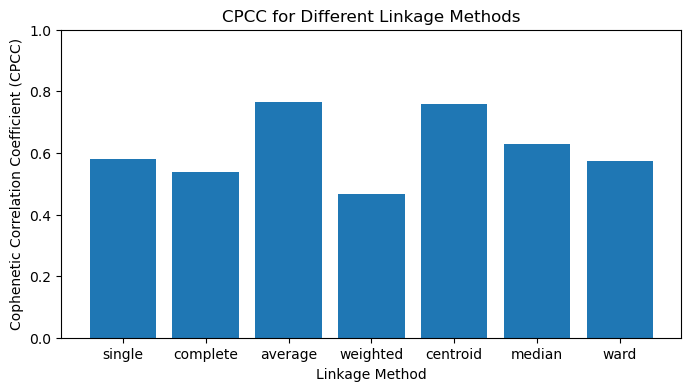

The best linkage method is 'average' with a CPCC of 0.767.


In [7]:
find_cpcc(cond_dist_mat_eu,linkage_methods);

From step 2, we select `average` linkage method for the case of Euclidean distance.  
Now we move on to experiment with the different number of clusters.  
Average-linkage is where the distance between each pair of observations in each cluster are added up and divided by the number of pairs to get an average inter-cluster distance.   
Equation:
\begin{equation*} D_{xy} = \frac{1}{|N_x||N_y|} \sum_{i \in N_x} \sum_{j \in N_y} d(x_{i},y_{j}) \end{equation*}

## Q1 Step 2.2:  
Find the [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of the N clusters and identify optimal number of clusters to have using the best linkage method.  
The simplest way is to find how the silhouette score changes with number of cluster, and select the number of cluster with the best silhouette score.  
----
The special thing about hierarchical clustering is that there's no predetermined number of groups to cluster.  
So we should choose the number of clusters that makes the most sense to us.  
----

In [8]:
# Define the chosen linkage method
chosen_linkage = 'average'

In [9]:
def find_best_sil_score(data, cond_dist_mat, chosen_linkage, n):
    """Find the silhouette scores of the N clusters, ranging from 2 to N.
    Args:
        data: array, standard scaled data to cluster
        cond_dist_mat: array, condensed distance matrix
        chosen_linkage: str, name of linkage chosen
        n: number of clusters to form for the selected linkage method
    Returns:
        best_score_dict: dict, {best_cluster_num: best score}
        cluster_score_dict: dict, {cluster_num: score}
    """
    # Define a range of cluster numbers to consider
    cluster_range = range(2, n+1)
    # Lists to store silhouette scores
    silhouette_scores = []
    cluster_score_dict = {}
    # Perform hierarchical clustering
    link_mat = linkage(cond_dist_mat, method=chosen_linkage)    
    # Calculate silhouette scores for different numbers of clusters
    for n_clusters in cluster_range:
        cluster_labels = fcluster(link_mat, t=n_clusters, criterion='maxclust')
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        cluster_score_dict[n_clusters] = silhouette_avg
        
    # Plot silhouette scores according to dendrogram level
    plt.figure(figsize=(16, 4))
    # plt.plot(dendrogram_dict['icoord'], silhouette_scores, marker='o', linestyle='-', markersize=6)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of clusters for {chosen_linkage} Linkage')
    plt.grid(True)
    plt.show()

    # Select the number of clusters that maximizes the silhouette score
    optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"The optimal number of clusters for {chosen_linkage} linkage is {optimal_num_clusters}, with a silhouette score of {max(silhouette_scores):.3f}.")
    return {optimal_num_clusters:max(silhouette_scores)}, cluster_score_dict

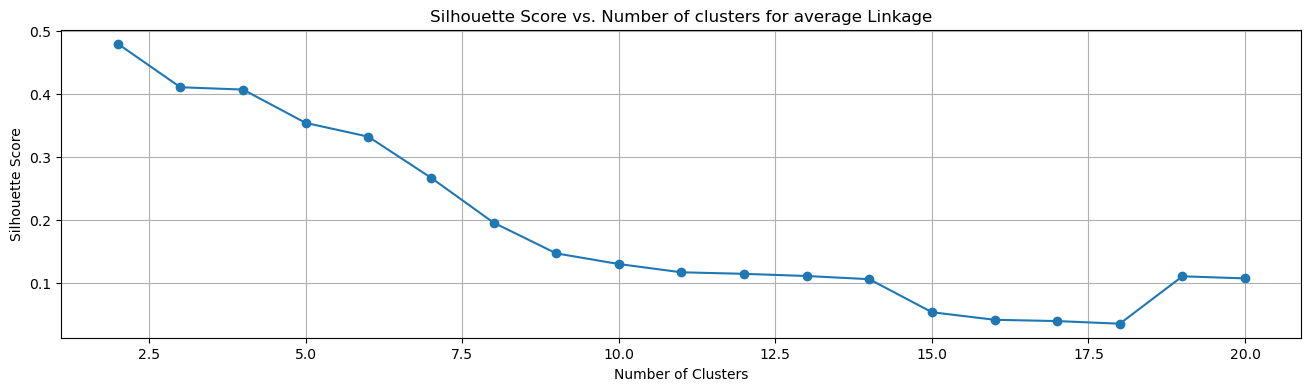

The optimal number of clusters for average linkage is 2, with a silhouette score of 0.479.


In [10]:
# Let n be 20. This means we examine up to 20 clusters
clus_opt, cluster_score_dict = find_best_sil_score(clus_ss, cond_dist_mat_eu, chosen_linkage, 20);

The Silhouette Score shows a constantly decreasing trend which is worrying.  
This is because according to the Silhouette Score, 2 cluster might be the best choice.  
However, knowing that hierarchical clustering tends to be very affected by outliers, and that they don't care about the balance in cluster size.  
The 2 clusters can end up with 1 data point in a cluster, and the rest of those 855 data points in another cluster...  
This is something we can't prevent, but we may not want to see.  
This means we need to use more aids to confirm our choice.  
----

One way to do so is to visualise how the clusters are split using a dendrogram.  
I will create a dendrogram below and observe how the clsuters are being split.  
If the last few clusters have long distance before they join, then that means they are split into distinct groups.  
Else, it means there are many outliers which didn't belong to any distinct groups.  

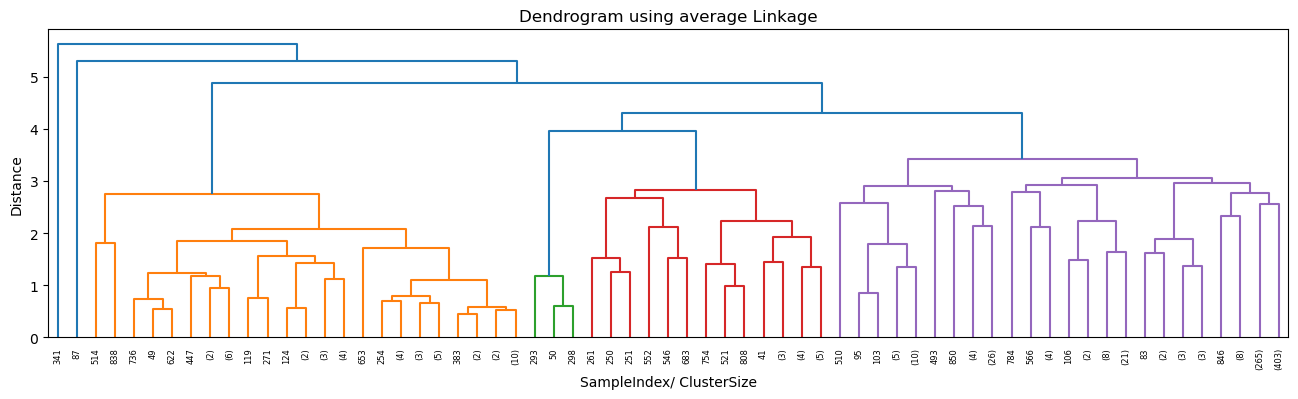

In [11]:
# Craete a dendrogram to visualise how the clusters are formed
# Perform hierarchical clustering
link_mat_eu = linkage(cond_dist_mat_eu, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(16, 4))
dendrogram_dict = dendrogram(link_mat_eu, p=8, labels=range(1, len(clus_ss)+1), truncate_mode='level', count_sort=True)
plt.xlabel('SampleIndex/ ClusterSize')
plt.ylabel('Distance')
plt.title(f'Dendrogram using {chosen_linkage} Linkage');

Very unfortunately, we encountered the case where outliers are not part of any clusters.  
This is evident from sample index 341 and 87.  
These 2 trouble makers are a class of their own...  
So we can not simply conclude using silhoutte score only.  
We have to dig deeper into the data.  
One way to do so is use clustermap to examine how these points are like.  
----

Examine the resultant calssification in a visually intuitive way, using cluster heatmap.  
The dendrogram is on the left hand side.  
The index are on the right handside, while the feature names are at the bottom.  

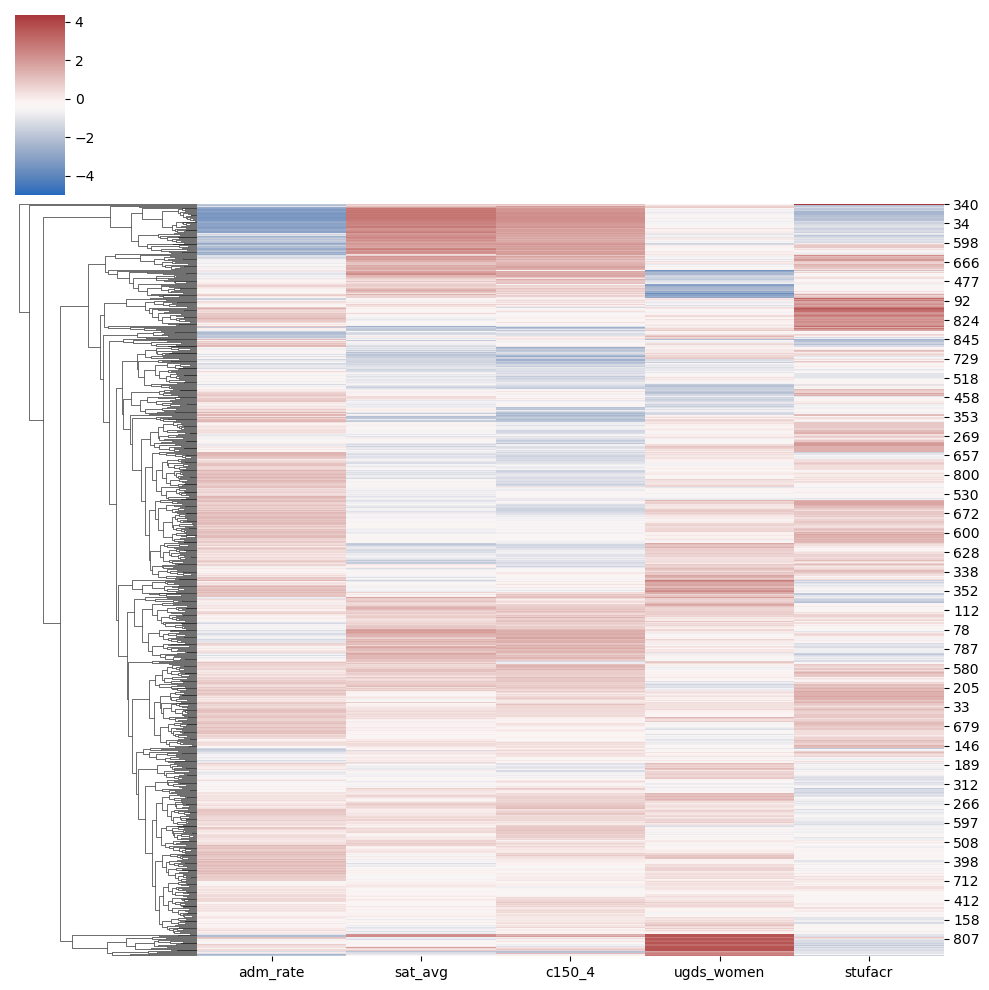

In [12]:
# Plot Clustermap of the MRCI_clus_2310 data
sns.clustermap(clus_ss_df, method=chosen_linkage, metric='euclidean', cmap="vlag", col_cluster=False);

From the cluster map, we can observe that it is actually really difficult to tell the different clusters apart.  
This is very unfortunate for us, as we do not have a distinctive split if we just use hierarchical clustering alone.   
We can rule out some of the really bad options using the cluster map though.  
Looking at the clsutermap, I can say that about 2 to 6 clusters will be a good choice.  
This means we have to further our prob into the problem.  
This time, I will use a trick called the elbow method.  
----

Elbow method will helpme find the point of diminishing return to continue clustering the data.  
According to [wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), the goal is to minimize the total intra-cluster variation (WSS).   
Therefore, we can implement the Elbow Method as a reference for determining the optimal number of clusters:

In [13]:
# Define a function to implement the elbow method.  
def find_wss(K, data, metric, linkage):
    """Calculate the total intra-cluster variation (WSS)
    Args:
        K: int, examine up to K number of clusters
        data: array, the standardised data to cluster
        metric: str, 'euclidean' or 'mahattan (city block)'
        linkage: str, linkage type
    Returns:
        wss_lst: list, intra-cluster variation for different n clusters
    """
    # Have a place holder to hold the wss results
    wss_lst = []
    # Loop through K number of clusters
    for i in range(K):
        # Create the cluster transformer object
        cluster = AgglomerativeClustering(n_clusters= i+1, metric=metric, linkage=linkage)  
        # Apply the cluster object
        cluster.fit_predict(data)
        # Obtain the cluster label
        label = cluster.labels_
        wss = []
        # For each cluster
        for j in range(i+1):
            # extract each cluster according to its index
            idx = [t for t, e in enumerate(label) if e == j]
            cluster = data[idx,]
            # calculate the WSS:
            cluster_mean = cluster.mean(axis=0)
            distance = np.sum(np.abs(cluster - cluster_mean)**2,axis=-1)
            wss.append(sum(distance))
        wss_lst.append(sum(wss))
    return wss_lst

Apply the defined function and plot a graph explained variation agianst number of clusters. 

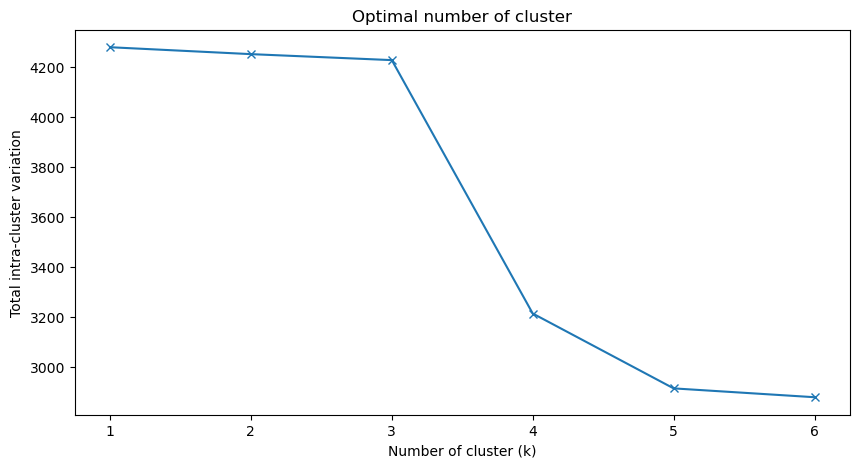

In [14]:
# Find the total intra-cluster variation for up to 6 clsuters
# 6 clusters is decided by looking at dendrogram and clutermap
wss_lst=find_wss(6, clus_ss, 'euclidean', chosen_linkage)
# Create the label
cluster_range = range(1, 7)
# Plot the result
plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster');
plt.xlabel('Number of cluster (k)');
plt.ylabel('Total intra-cluster variation');
plt.plot(cluster_range, wss_lst, marker = "x");

In [15]:
# Print the score for 5 clusters
print(f"The Silhouette Score for 5 clusters is : {cluster_score_dict[5]:.3}")

The Silhouette Score for 5 clusters is : 0.354


The gain in explained variance reduces significantly from 4 to 5 to 6 (‘elbow’ is at k = 5).   
So, optimal number of clusters could be 5.  
We have finally concluded that the near optimal number of clusters to have is 5.  
The Silhouette Score is 0.354.  
----
Now we can plot a final fancy dendrogram to show the clustering process, just for fun.  =D  

In [16]:
# This code is purely for visualisation purpose and does not play a part in analysis
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(10,5))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
# the following code is from
# [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/]

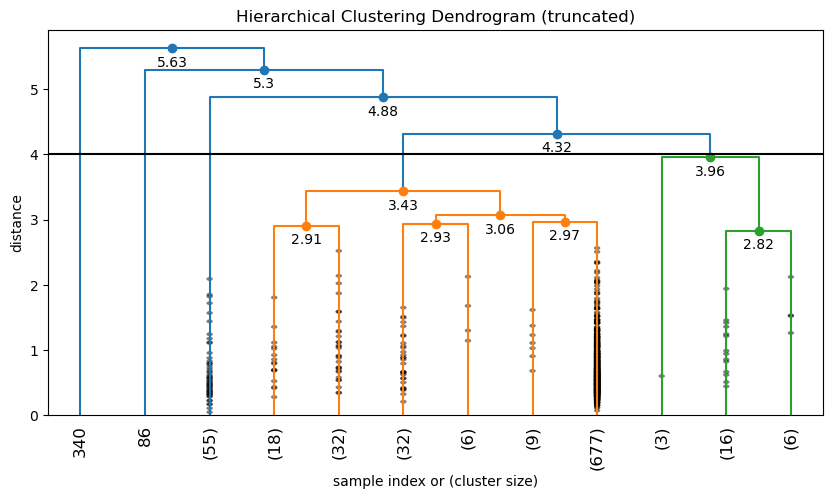

In [17]:
# Use the fancy dendrogram function
fancy_dendrogram(
    link_mat_eu,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=4,  # a horizontal cut-off line
)

plt.show()

This is a much neater truncated dendrogram that indicates the distance at the point of merging into 1 cluster.   
By cutting at distance = 4, I am able to get a total of 5 clusters.  

## Q1 Step 2.3:
Now that we have finally determined the optimal numbe of clusters to have is 5, we should create the corresponding label and use them to examine the data in each cluster.  
To do so, we first label the data and decided which cluster they belongs to.   
I will use sklearn library to do so.  
Steps to take now:
* Create the label using sklearn
* Split the dataset
* Examine the different clusters
* Outline the properties/differences of the clusters I identified.

In [18]:
# Set the number of cluster to have to be 5
num_cluster = 5

In [19]:
# Create cluster object
cluster=AgglomerativeClustering(n_clusters=num_cluster, metric='euclidean', linkage=chosen_linkage)
# Fit the standard scaled data into the cluster object and predict the label
cluster.fit_predict(clus_ss)
# Find the label or result of the clustering
pred_label = cluster.labels_
# Reshape into the correct shape of (856,1), instead of default (856,)
pred_label = pred_label.reshape(-1,1)
# Stack the array and data together
# Append the label to the standard scaled data
clus_ss_w_label = np.hstack((clus_ss, pred_label))
# Change the matrix into dataframe for simpler analysis
clus_eucli_res_df = pd.DataFrame(clus_ss_w_label, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr", "label"])

In [20]:
# Display the frist 5 rows to take a look at it.
clus_eucli_res_df.head()

,adm_rate,sat_avg,c150_4,ugds_women,stufacr,label
0,-0.100214,-1.637257,-1.969576,0.157315,1.135143,1.0
1,0.737952,0.801589,0.147183,0.391960,1.402825,1.0
2,0.002207,1.067360,0.040668,-1.487806,1.402825,1.0
3,1.205524,-1.629440,-1.947411,0.639641,-0.203263,1.0
4,0.260980,0.629619,0.749333,-0.125128,1.402825,1.0


Now we have the dataset labeled, it make sense to see the size of each of these clusters.

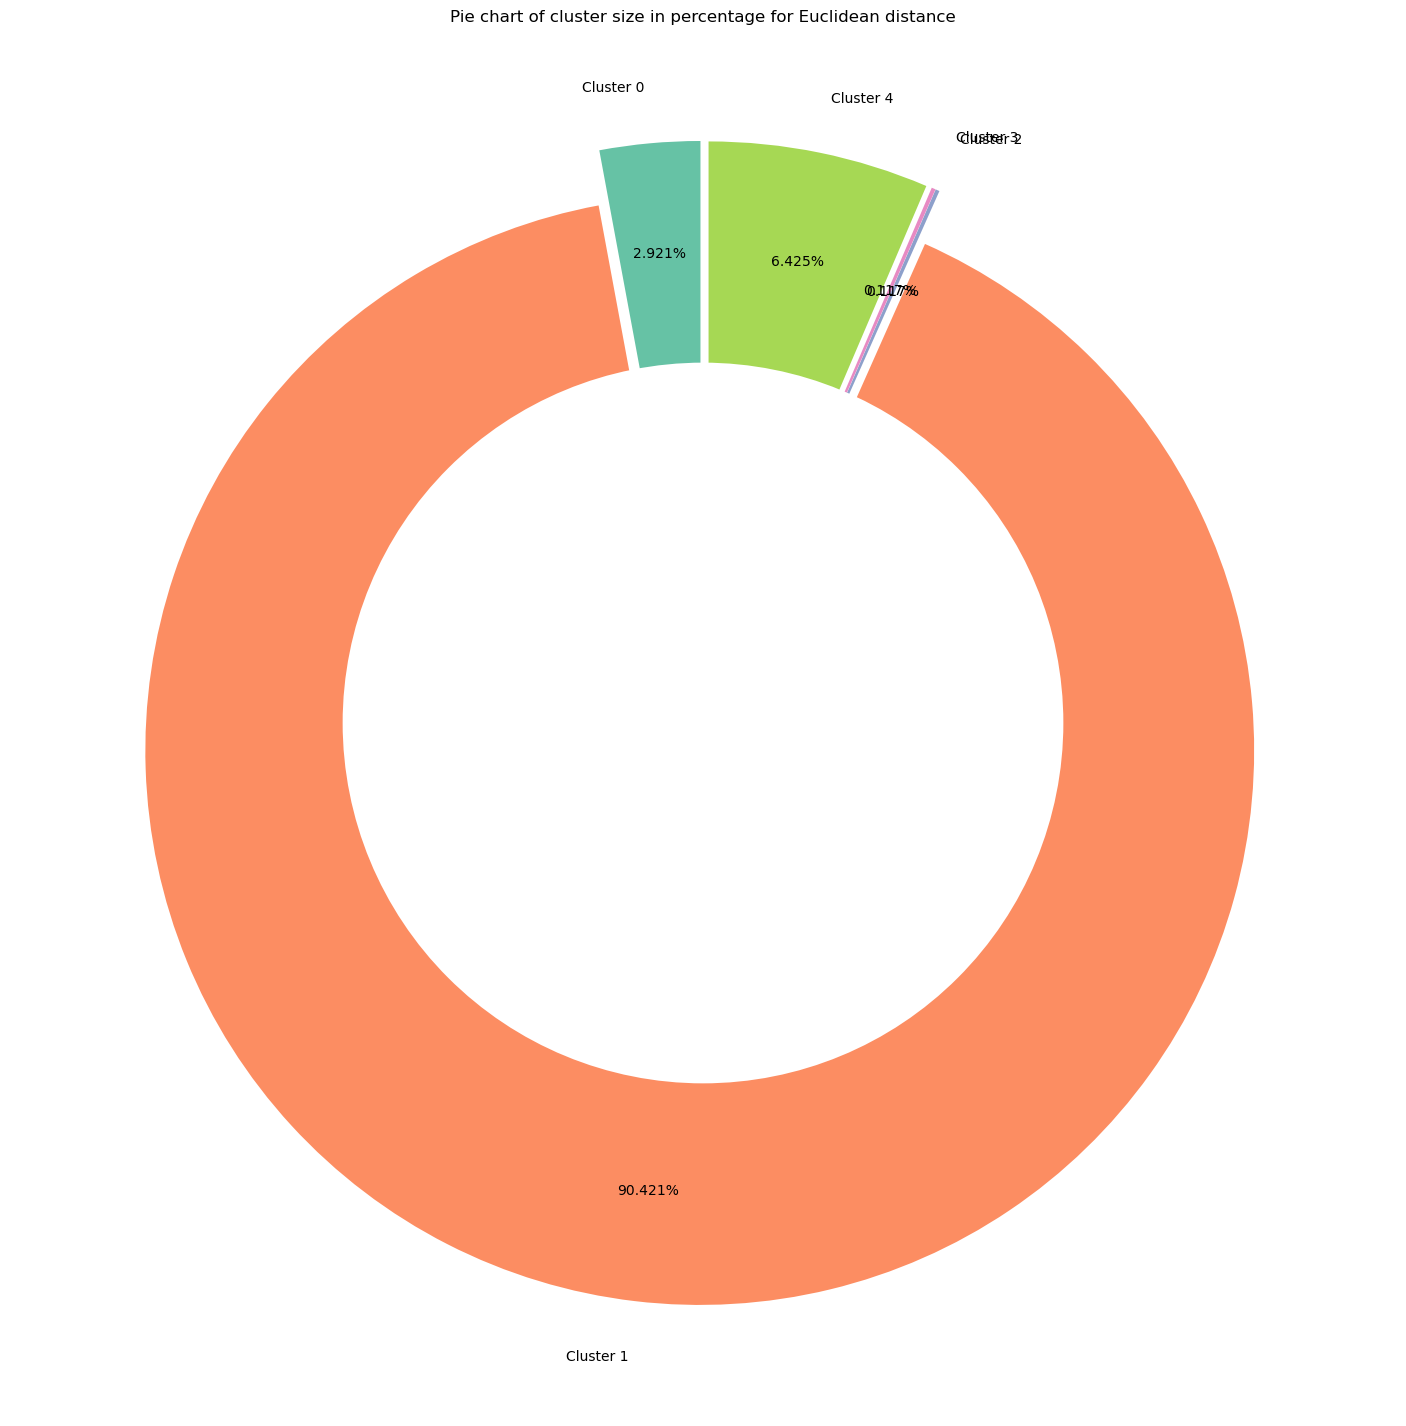

In [21]:
# Declare data
data = list(clus_eucli_res_df.groupby('label').count()['adm_rate'])
# Declare the key
keys = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'] 

plt.figure(figsize=(18,18))

plt.pie(
    x=data, labels=keys,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.3f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title("Pie chart of cluster size in percentage for Euclidean distance")
plt.show()

In [22]:
# Find the number of university in each cluster
clus_eucli_res_df.groupby('label').count()["adm_rate"]

label
0.0     25
1.0    774
2.0      1
3.0      1
4.0     55
Name: adm_rate, dtype: int64

We can see that cluster 2 and 3 only have 1 university in them.   
This accounts for 0.117% of the data.  
The largest group is from cluster 1, it have 774 entries and accounts for 90.4% of the unversities.  
This tells us that majority of the university doesn't really standout.  
----
We now examine the different clusters.   
We can use the seaborn pair plot to visualise how the clusters are formed. 

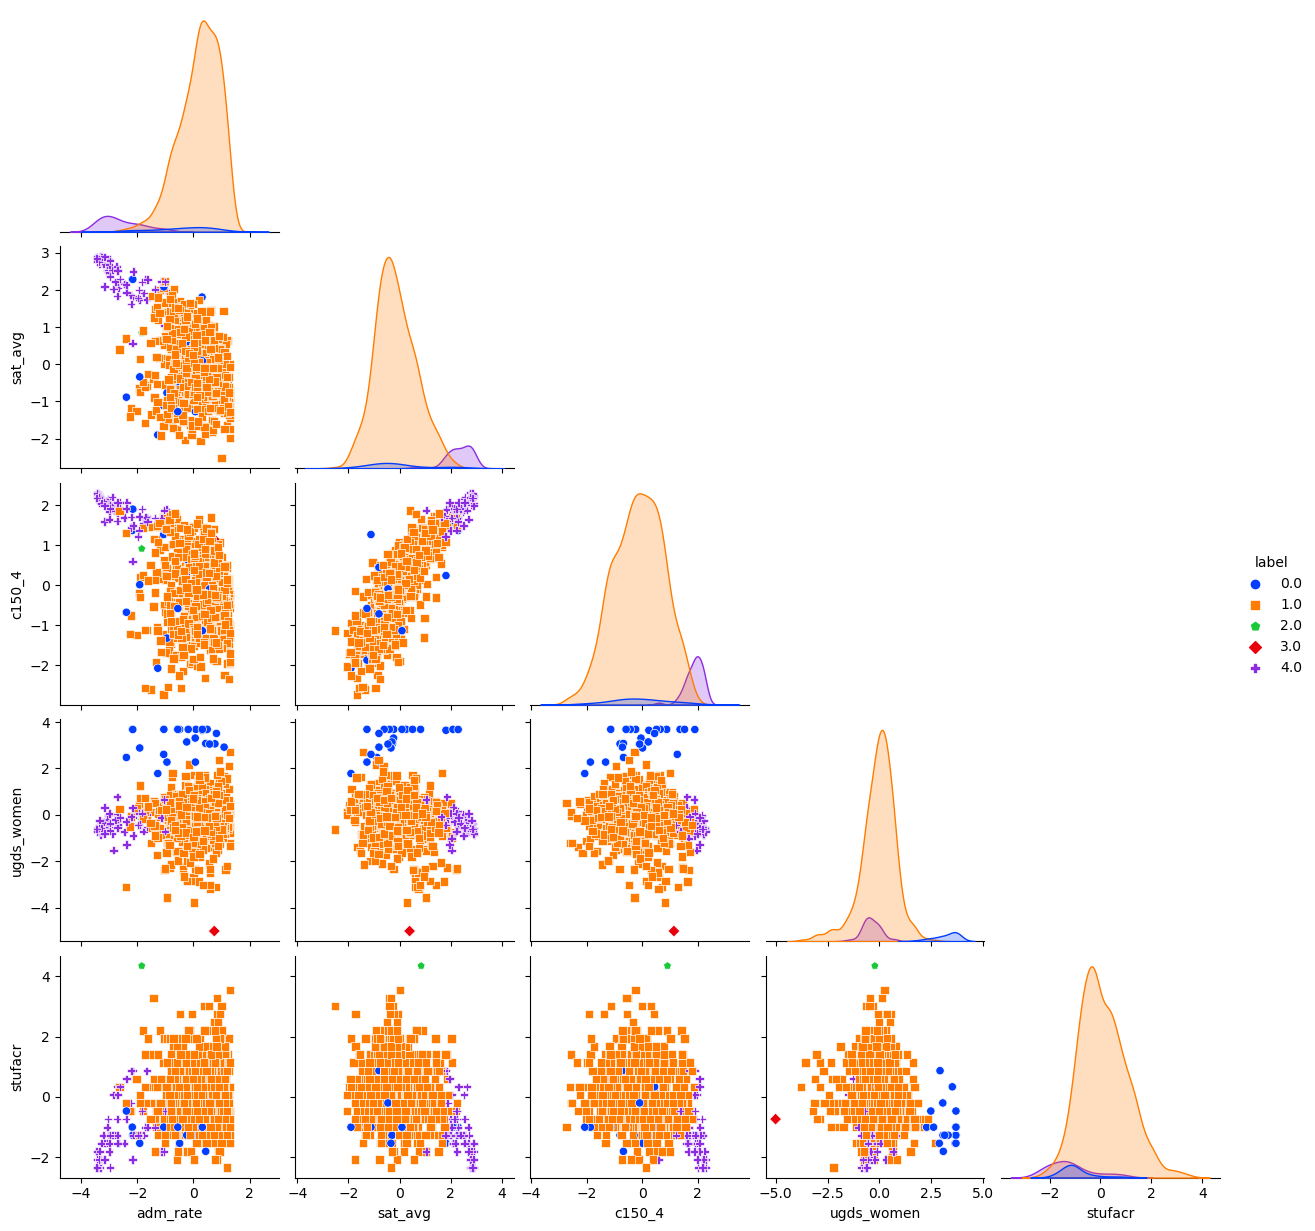

In [23]:
# Examine the different clusters using pairplot
sns.pairplot(clus_eucli_res_df, hue='label', palette='bright', corner=True, markers=['o','s', 'p', 'D', 'P'], );

From this graph, it is immediately apparent why the universities are clustered as such.  
cluster 0: High percentage of undergraduates who are women.  
cluster 1: The "normal" unvisersities.  
cluster 2: Extremely high student to faculty ratio. (Outlier)  
cluster 3: Extremely low percentage of undergraduates who are women. (Outlier)  
cluster 4: The "top schools" with high SAT average, low admission rate, low student faculty ratio, but most people still graduate in 4 years.  
Amazing! 

I will now split the data into sub groups and have their statistics described, just in case.  

### Cluster 0
High women enrollment rate.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,-0.381351,-0.080773,-0.084466,3.222159,-0.974185
std,1.011276,1.137591,1.017038,0.567050,0.595152
min,-2.391069,-1.903029,-2.069318,1.782448,-1.809350
25%,-1.055149,-0.808675,-0.673538,2.919171,-1.273987
50%,-0.185811,-0.339666,-0.088628,3.510129,-1.006306
75%,0.437123,0.246595,0.519063,3.685678,-1.006306
max,1.092219,2.286783,1.903145,3.685678,0.867462


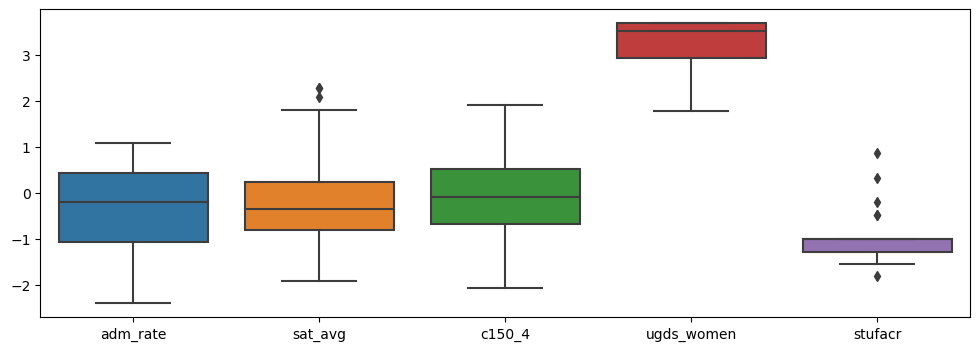

In [24]:
c0_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==0.0].drop(columns="label")
display(c0_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c0_eucli_df);

### Cluster 2
The normal universities.   
It is normally distributed most of the time for all features.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,774.000000,774.000000,774.000000,774.000000,774.000000
mean,0.198264,-0.164252,-0.133195,-0.070350,0.111107
std,0.715014,0.798636,0.892925,0.837259,0.935310
min,-2.633514,-2.528374,-2.727496,-3.775158,-2.344712
25%,-0.247041,-0.730507,-0.766200,-0.498387,-0.470944
50%,0.291656,-0.249773,-0.114795,0.015659,0.064419
75%,0.757373,0.356030,0.524758,0.444103,0.599781
max,1.304976,2.239882,1.872361,2.705384,3.544274


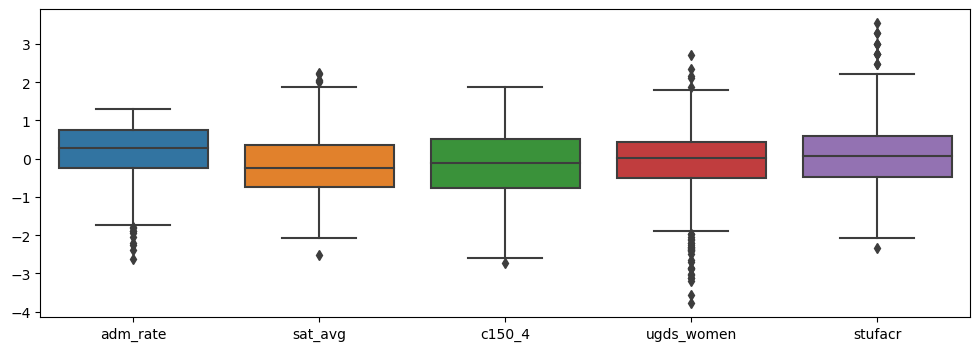

In [25]:
c1_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==1.0].drop(columns="label")
# c1_eucli_df.drop(["label"], inplace=True)
display(c1_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c1_eucli_df);

### Cluster 3
The university with highest student to faculty ratio and is difficult to get in, but doesn't need an exceptional result result.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,-1.843342,0.840673,0.916186,-0.222462,4.347318
std,NaN,NaN,NaN,NaN,NaN
min,-1.843342,0.840673,0.916186,-0.222462,4.347318
25%,-1.843342,0.840673,0.916186,-0.222462,4.347318
50%,-1.843342,0.840673,0.916186,-0.222462,4.347318
75%,-1.843342,0.840673,0.916186,-0.222462,4.347318
max,-1.843342,0.840673,0.916186,-0.222462,4.347318


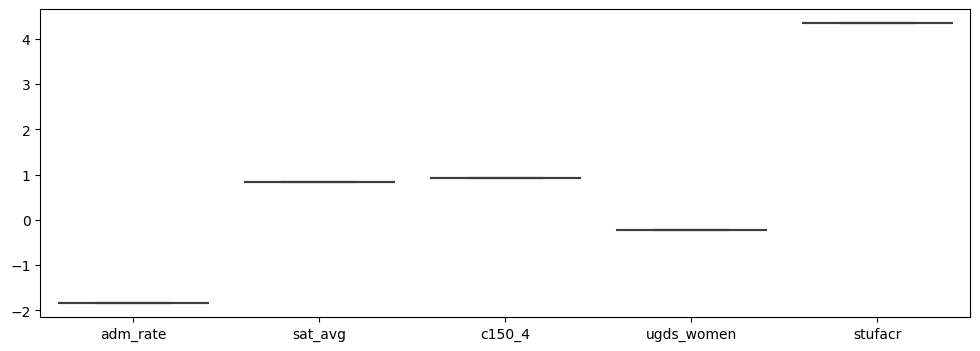

In [26]:
c2_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==2.0].drop(columns="label")
# c1_eucli_df.drop(["label"], inplace=True)
display(c2_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c2_eucli_df);

### Cluster 3
The monk temple...   
The university with lowest women enrollment rate.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.743395,0.387297,1.148303,-5.004871,-0.738625
std,NaN,NaN,NaN,NaN,NaN
min,0.743395,0.387297,1.148303,-5.004871,-0.738625
25%,0.743395,0.387297,1.148303,-5.004871,-0.738625
50%,0.743395,0.387297,1.148303,-5.004871,-0.738625
75%,0.743395,0.387297,1.148303,-5.004871,-0.738625
max,0.743395,0.387297,1.148303,-5.004871,-0.738625


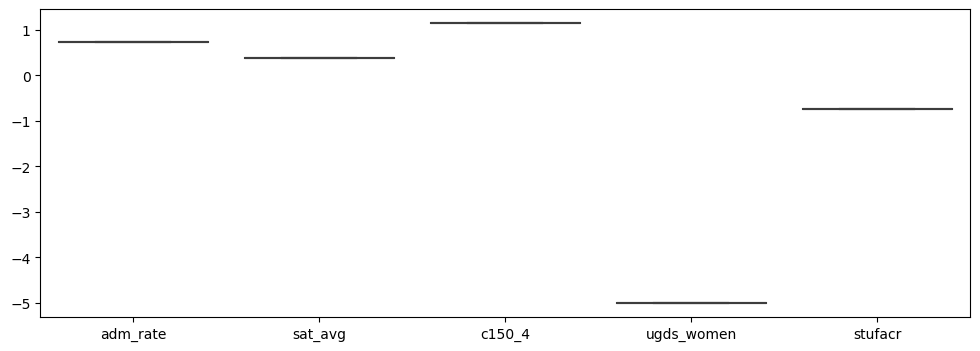

In [27]:
c3_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==3.0].drop(columns="label")
display(c3_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c3_eucli_df);

### Cluster 4
The top schools.   
High SAT score, low admission rate, high graduation rate.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,55.000000,55.000000,55.000000,55.000000,55.000000
mean,-2.596774,2.325867,1.875271,-0.379555,-1.186383
std,0.711985,0.480636,0.315271,0.430278,0.872807
min,-3.447435,0.567084,0.602798,-1.519092,-2.344712
25%,-3.170108,2.024920,1.692578,-0.670894,-1.809350
50%,-2.733460,2.364951,1.906839,-0.413654,-1.273987
75%,-2.149366,2.732341,2.074924,-0.112092,-0.738625
max,-0.972025,2.904311,2.309504,0.777820,0.867462


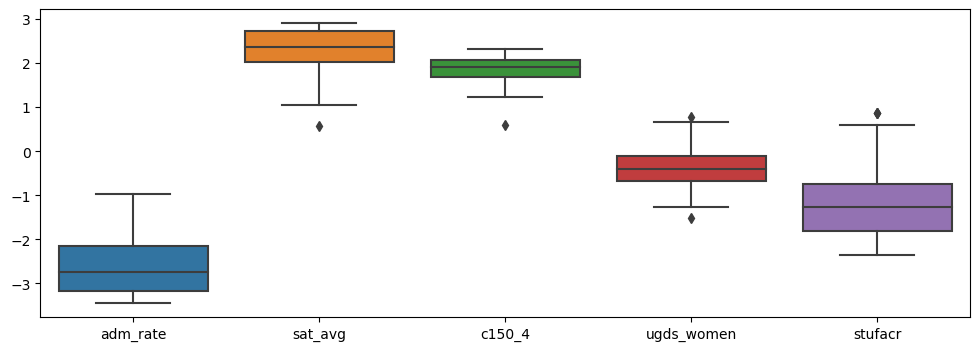

In [28]:
c4_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==4.0].drop(columns="label")
display(c4_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c4_eucli_df);

With this, I have completed my analysis on clustering with Euclidean distance using average linkage method.
____

## Q1 Step 3:
Try the different linkage methods for Manhattan distance, and select the best linkage method.   

Manhattan distance is given by:  
$d(p,q) = \sum_{i=1}^n |p_i - q_i|$   
where $\mathbf{p}$ and $\mathbf{q}$ are two points in n-space, and $p_i$ and $q_i$ are their coordinates in the i-th dimension.

For the rest of the question, I will follow what I have done previously.  

1. Find the pair-wise distance using [scipy.spatial.distance.pdist()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) method.   
2. Find the [CPCC](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) for each linkage method using scipy method.  
3. Select the linkage method with the highest CPCC. 

The typical linkage methods are:
* Single Linkage
* Complete Linkage
* Centroid Linkage
* Average Linkage

Note that ward and median requires euclidean metric!

In [29]:
# Calculate pairwise distances, now using mahanttan distance or city block distance. 
cond_dist_mat_man = pdist(clus_ss, metric='cityblock')

In [30]:
# List of linkage methods to compare, as stated on scipy documentation page
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid']

The CPCC score for each method:
single: 0.562
complete: 0.641
average: 0.709
weighted: 0.355
centroid: 0.708


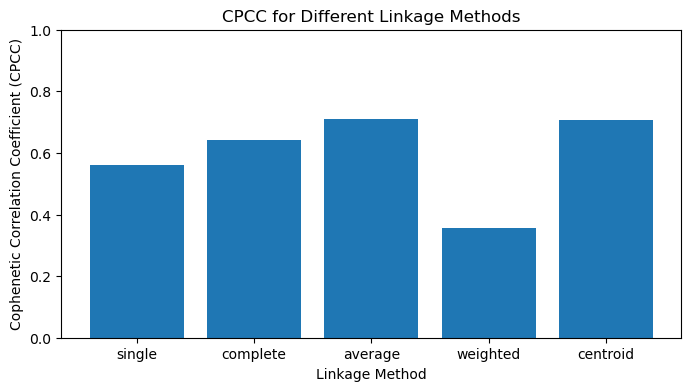

The best linkage method is 'average' with a CPCC of 0.709.


In [31]:
find_cpcc(cond_dist_mat_man, linkage_methods);

For the case of Mahattan distance, the average linkage method is still the better method to use.  

## Q1 Step 3.2:
Find how silhouette score changes with number of cluster, and select the number of cluster with the best silhouette score.

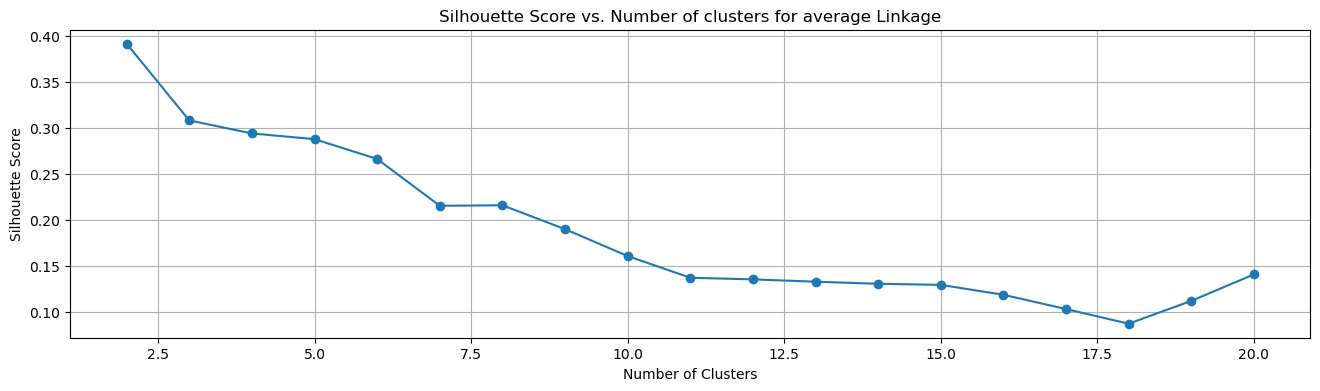

The optimal number of clusters for average linkage is 2, with a silhouette score of 0.392.


In [32]:
# Let n be 20. This means we examine up to 20 clusters
clus_opt, cluster_score_dict =find_best_sil_score(clus_ss, cond_dist_mat_man, chosen_linkage, 20);

As always, we should not just look at silhouette score.  
Let us take a look at the dendrogram now.  

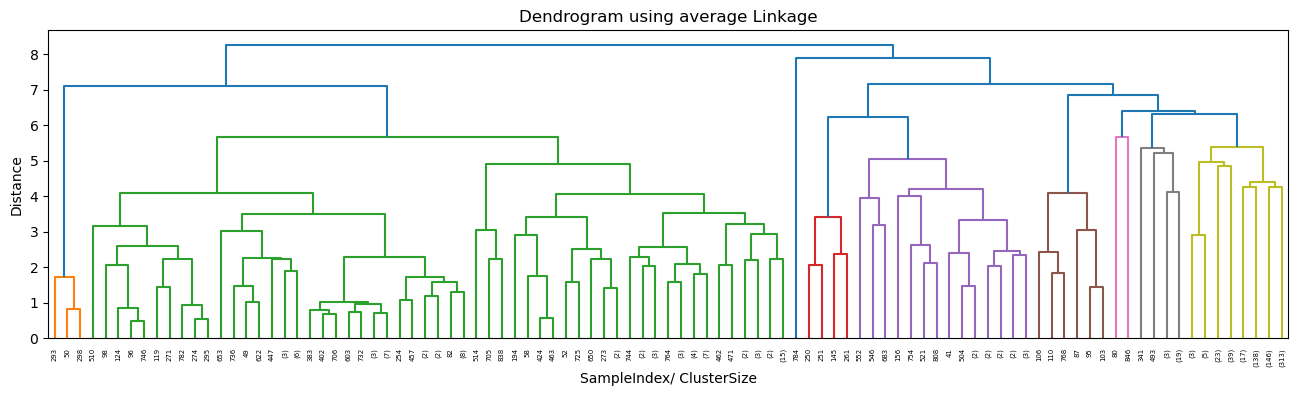

In [33]:
# Craete a dendrogram to visualise how the clusters are formed
# Perform hierarchical clustering
link_mat_man = linkage(cond_dist_mat_man, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(16, 4))
dendrogram_dict_man = dendrogram(link_mat_man, p=8, labels=range(1, len(clus_ss)+1), truncate_mode='level', count_sort=True)
plt.xlabel('SampleIndex/ ClusterSize')
plt.ylabel('Distance')
plt.title(f'Dendrogram using {chosen_linkage} Linkage');

Now, this dendrogram is very different from the one generated using Euclidean metric.   
It is less prone to effects of outliers, as only 1 university is considered as outlier, 2 distinct clusters can be seen.  
We examine the clustermap to confirm.  

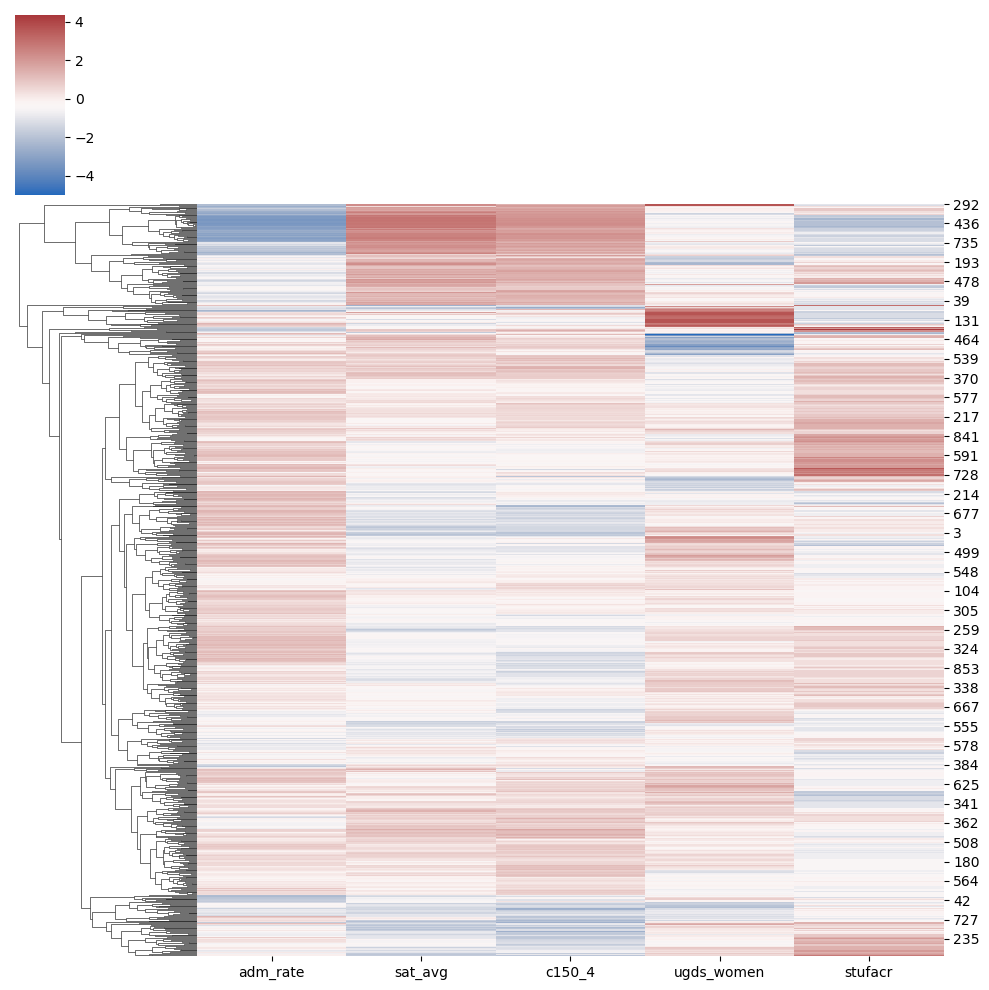

In [34]:
# Plot Clustermap of the MRCI_clus_2310 data
sns.clustermap(clus_ss_df, method=chosen_linkage, metric='cityblock', cmap="vlag", col_cluster=False);

2 to 3 distinct clusters can be observed from the clustermap, just like shown in the dendrogram.  
We still examine up to 6 cluster's intra-cluster distance. 

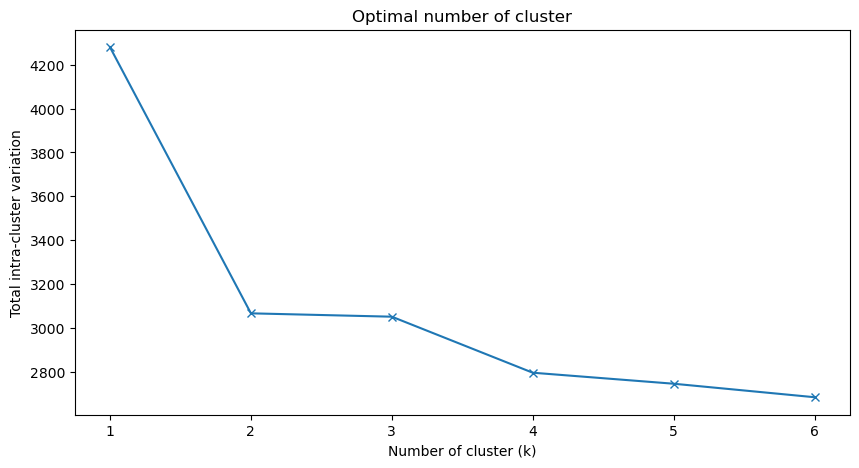

In [35]:
# Find the total intra-cluster variation for up to 6 clsuters
# 6 clusters is decided by looking at dendrogram and clutermap
wss_lst=find_wss(6, clus_ss, 'cityblock', chosen_linkage)
# Create the label
cluster_range = range(1, 7)
# Plot the result
plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster');
plt.xlabel('Number of cluster (k)');
plt.ylabel('Total intra-cluster variation');
plt.plot(cluster_range, wss_lst, marker = "x");

In [36]:
# Print the score for 4 clusters
print(f"The Silhouette Score for 4 clusters is : {cluster_score_dict[4]:.3}")

The Silhouette Score for 4 clusters is : 0.294


The gain in explained variance reduces significantly from 3 to 4 to 5 ('elbow' is at k = 4).  
So, optimal number of clusters could be 4.  
The Silhouette Score for 4 clusters is : 0.294  
We have finally concluded that the near optimal number of clusters to have is 4.  

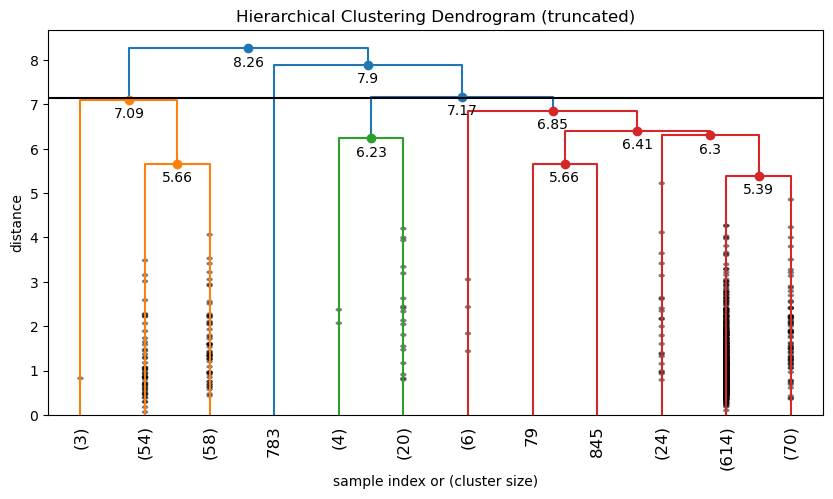

In [37]:
# Use the fancy dendrogram function
fancy_dendrogram(
    link_mat_man,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=7.15,  # a horizontal cut-off line
)

plt.show()

## Q1 Step 3.3:  
Now that we have finally determined the optimal numbe of clusters to have is 4, we should create the corresponding label and use them to examine the data in each cluster.  
To do so, we first label the data and decided which cluster they belongs to.   
I will use sklearn library to do so.  
Steps to take now:
* Create the label using sklearn
* Split the dataset
* Examine the different clusters
* Outline the properties/differences of the clusters I identified.

In [38]:
# Set the number of cluster to have to be 4 for manhanttan distance
num_cluster = 4

In [39]:
# Create cluster object
cluster=AgglomerativeClustering(n_clusters=num_cluster, metric='cityblock', linkage=chosen_linkage)
# Fit the standard scaled data into the cluster object and predict the label
cluster.fit_predict(clus_ss)
# Find the label or result of the clustering
pred_label = cluster.labels_
# Reshape into the correct shape of (856,1), instead of default (856,)
pred_label = pred_label.reshape(-1,1)
# Stack the array and data together
# Append the label to the standard scaled data
clus_ss_w_label = np.hstack((clus_ss, pred_label))
# Change the matrix into dataframe for simpler analysis
clus_man_res_df = pd.DataFrame(clus_ss_w_label, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr", "label"])

A dataframe with the labels for each university using the mahattan distance is created.  
Now analyse the data.  

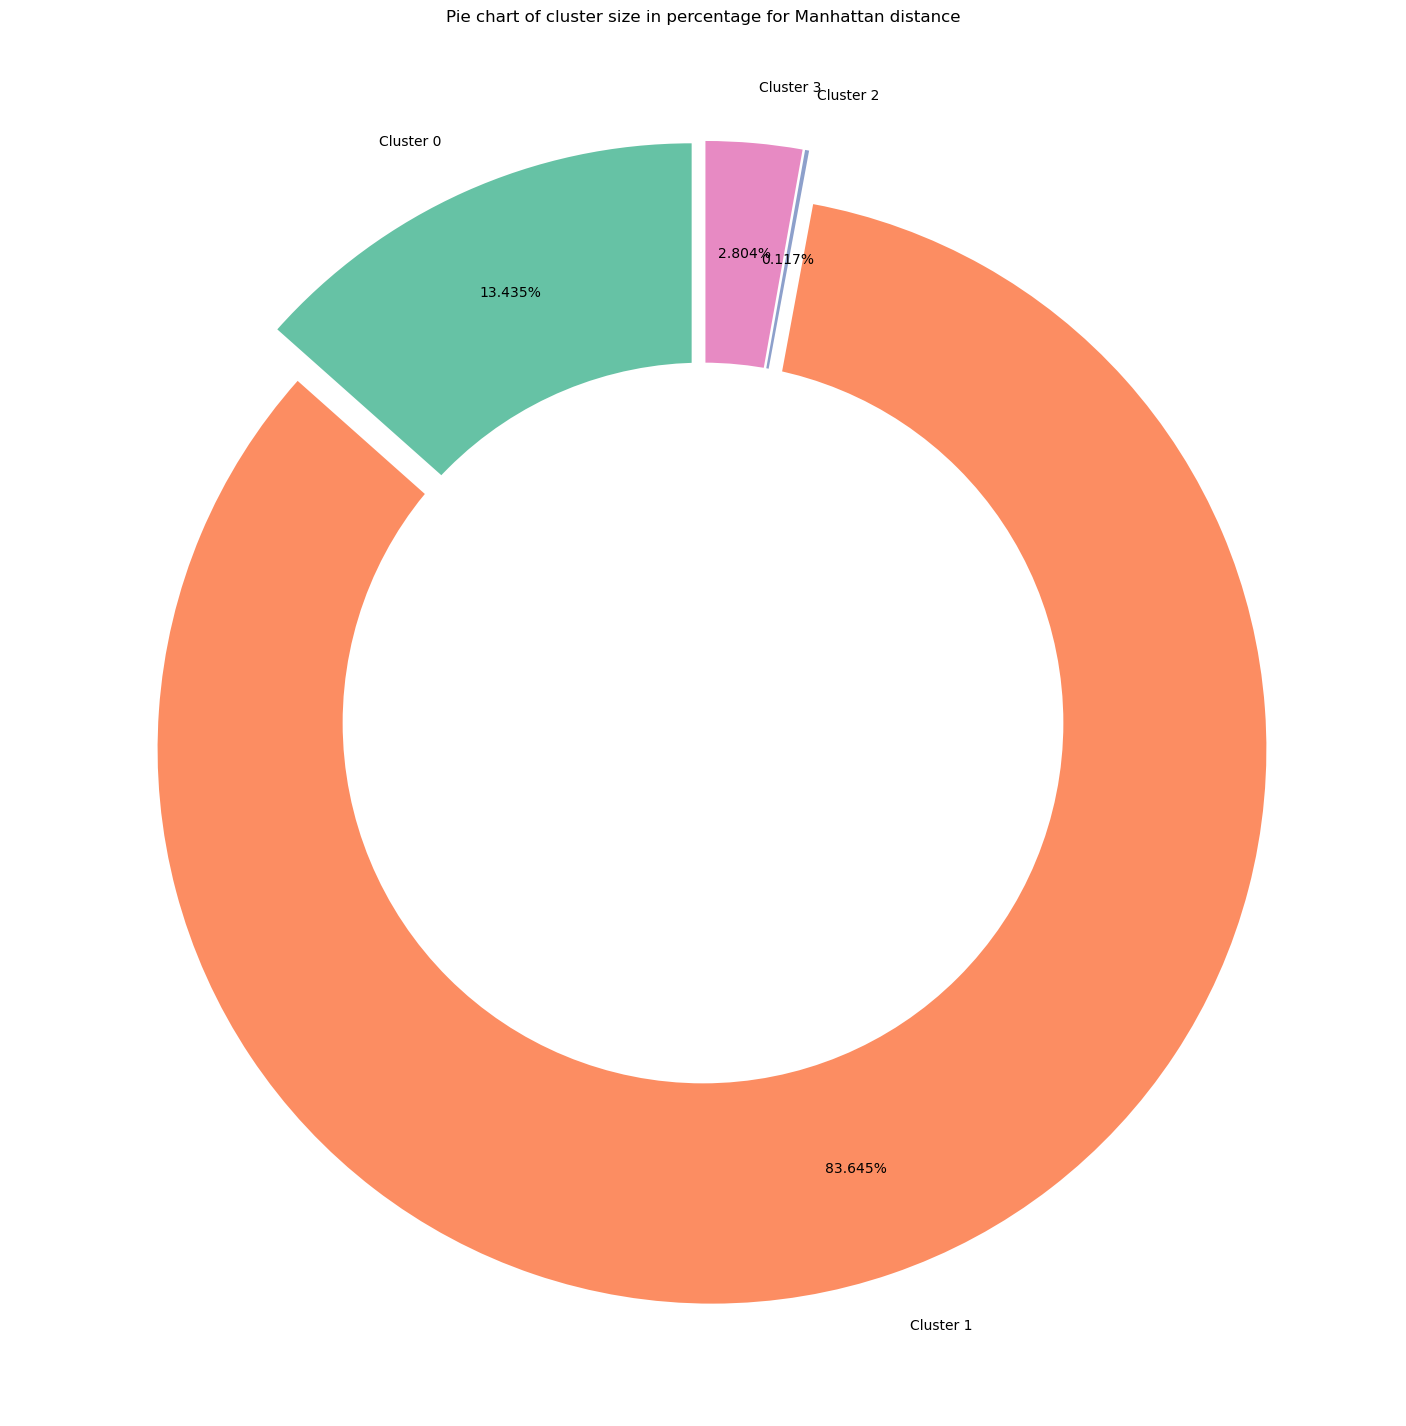

In [40]:
# Plot the pie chart to visualise the proportions.
# Declare data
data = list(clus_man_res_df.groupby('label').count()['adm_rate'])
# Declare the key
keys = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'] 

plt.figure(figsize=(18,18))

plt.pie(
    x=data, labels=keys,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.3f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title("Pie chart of cluster size in percentage for Manhattan distance")
plt.show()

In [41]:
# Find the number of university in each cluster
clus_man_res_df.groupby('label').count()["adm_rate"]

label
0.0    115
1.0    716
2.0      1
3.0     24
Name: adm_rate, dtype: int64

Majoirty of the schools, 716 of them, are in cluster 1.  
Cluster 2 is the odd one out, with 1 school, likely outlier.  
Examine pairplot for property/ difference in cluster.  

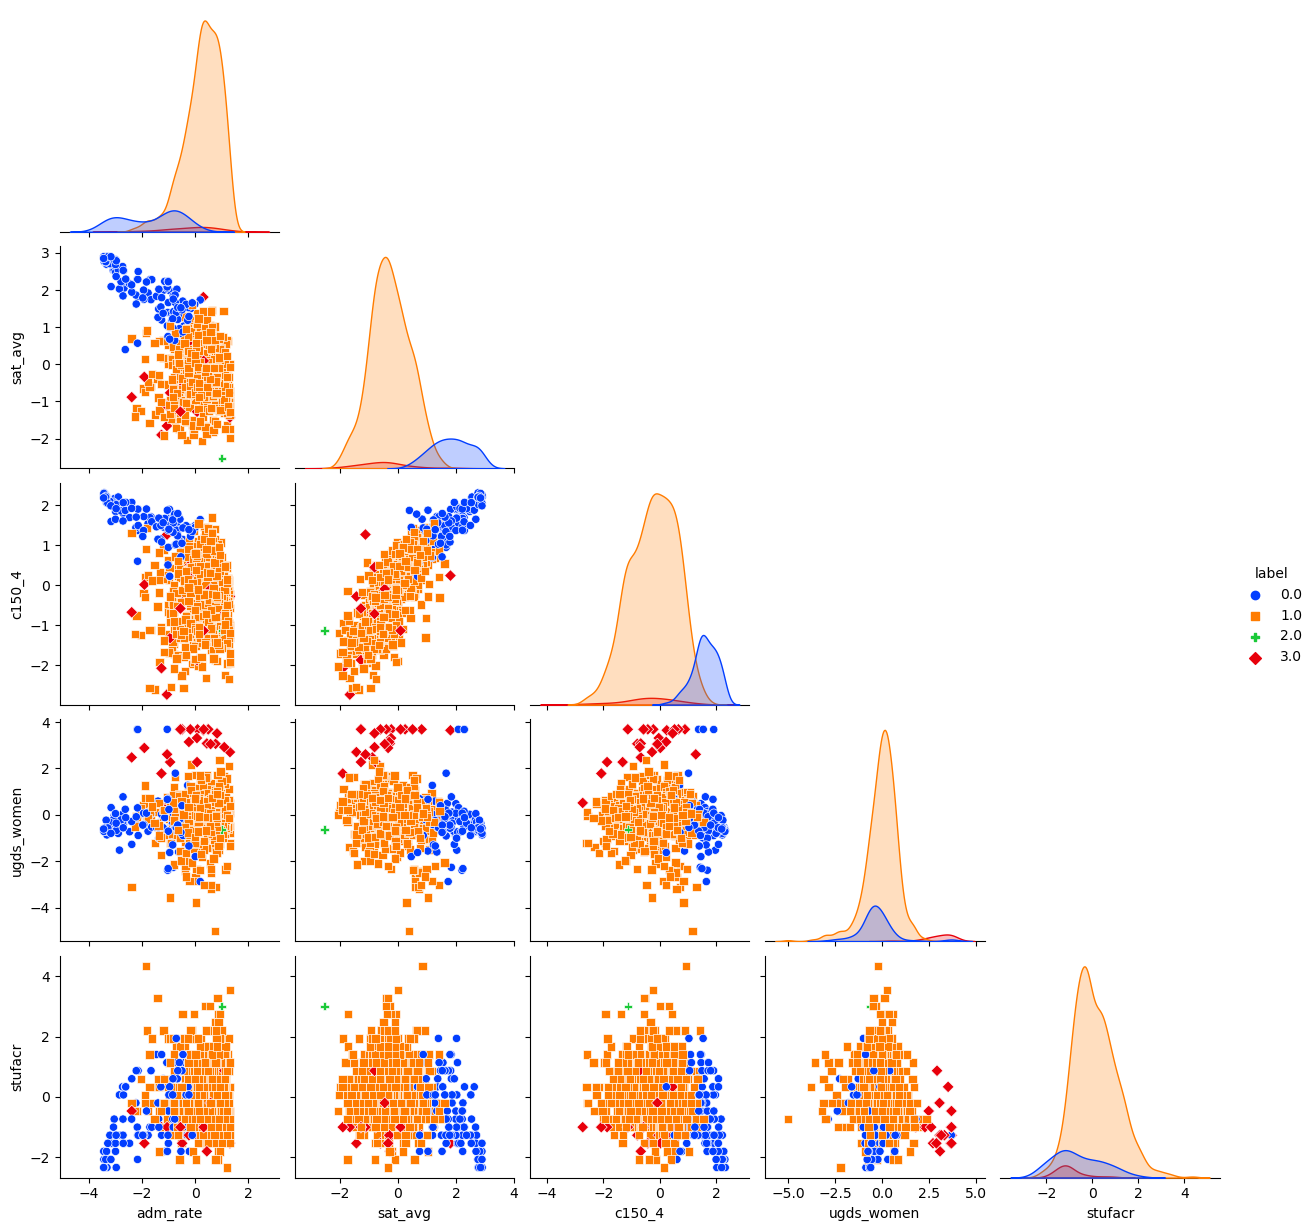

In [42]:
# Examine the different clusters using pairplot
sns.pairplot(clus_man_res_df, hue='label', palette='bright', corner=True, markers=['o','s', 'P', 'D'], );

The most prominent difference we can clearly see how the schools are clustered!  
Cluster 0: High SAT average, high percentage of students graduate in time, distribution of admission rate is 2 peaked.   
Cluster 1: The normal schools, with okay admission rate.   
Cluster 2: The outlier with lowest SAT, but not the highest admission rate. (Outlier)  
Cluster 3: School woth high admission rate for women.  

### Cluster 0
Better school with higher SAT average.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,115.000000,115.000000,115.000000,115.000000,115.000000
mean,-1.656051,1.843128,1.582663,-0.306564,-0.629225
std,1.093813,0.656739,0.432270,0.944513,1.049317
min,-3.447435,0.395114,0.226608,-2.873079,-2.344712
25%,-2.719359,1.348765,1.369646,-0.690882,-1.273987
50%,-1.293635,1.841225,1.595298,-0.365856,-0.738625
75%,-0.732302,2.290691,1.904685,0.029130,0.064419
max,0.186762,2.904311,2.309504,3.685678,1.938187


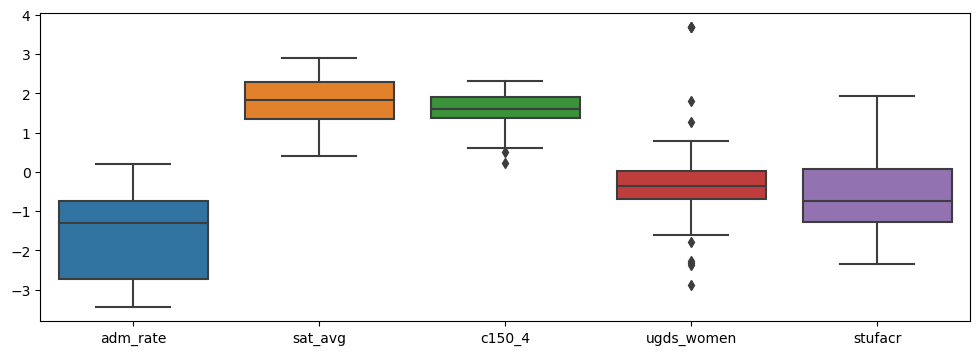

In [43]:
c0_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==0.0].drop(columns="label")
display(c0_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c0_man_df);

### Cluster 2
The normal school, even the distribution seems very normal... 

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,716.000000,716.000000,716.000000,716.000000,716.000000
mean,0.270036,-0.276062,-0.238767,-0.051453,0.129843
std,0.679924,0.683437,0.819249,0.842109,0.940060
min,-2.395522,-2.059365,-2.598200,-5.004871,-2.344712
25%,-0.106151,-0.753957,-0.813301,-0.455586,-0.470944
50%,0.344103,-0.324032,-0.200376,0.036951,0.064419
75%,0.792626,0.186015,0.420706,0.479952,0.599781
max,1.304976,1.606720,1.695656,2.351679,4.347318


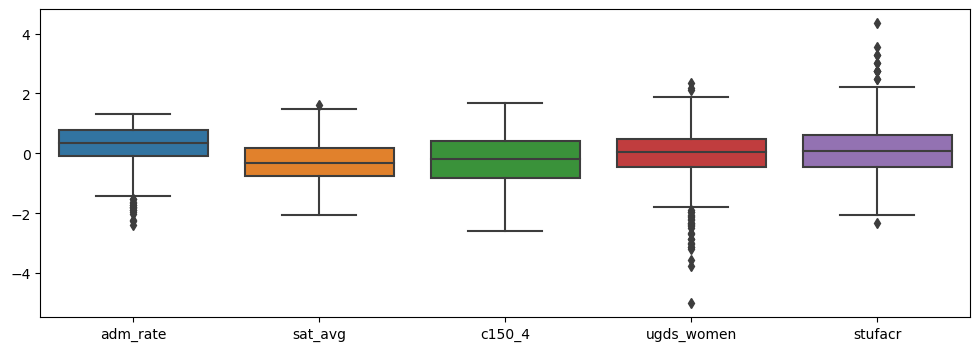

In [44]:
c1_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==1.0].drop(columns="label")
display(c1_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c1_man_df);

### Cluster 2
Outlier in terms of SAT.

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,1.00000,1.000000,1.000000,1.000000,1.000000
mean,0.99722,-2.528374,-1.126689,-0.630049,3.008912
std,NaN,NaN,NaN,NaN,NaN
min,0.99722,-2.528374,-1.126689,-0.630049,3.008912
25%,0.99722,-2.528374,-1.126689,-0.630049,3.008912
50%,0.99722,-2.528374,-1.126689,-0.630049,3.008912
75%,0.99722,-2.528374,-1.126689,-0.630049,3.008912
max,0.99722,-2.528374,-1.126689,-0.630049,3.008912


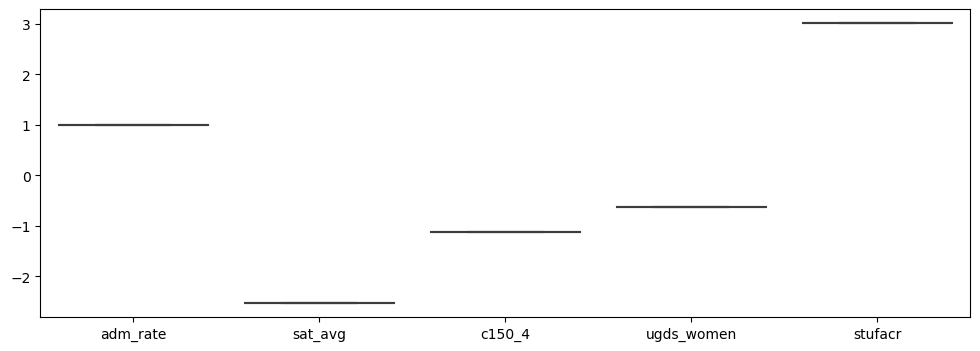

In [45]:
c2_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==2.0].drop(columns="label")
display(c2_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c2_man_df);

### Cluster 3
High admission for women.  

,adm_rate,sat_avg,c150_4,ugds_women,stufacr
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.162371,-0.490465,-0.413432,3.030229,-0.983999
std,0.928769,0.819939,0.945647,0.774146,0.616080
min,-2.391069,-1.903029,-2.727496,0.516235,-1.809350
25%,-0.661671,-0.945469,-0.732952,2.681050,-1.273987
50%,0.065292,-0.449101,-0.350914,3.110364,-1.006306
75%,0.472995,-0.236093,0.228763,3.685678,-1.006306
max,1.304976,1.809957,1.269595,3.685678,0.867462


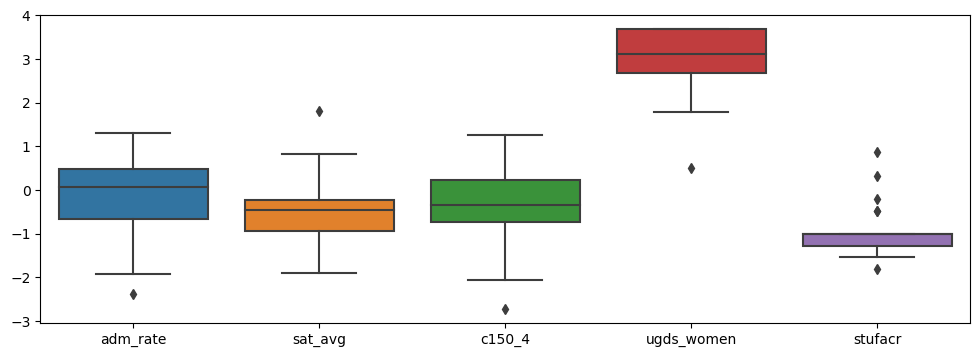

In [46]:
c3_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==3.0].drop(columns="label")
display(c3_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c3_man_df);

With this, Qustion 1 is completed!

----

# Q1 Summary
For both Euclidean and Manhanttan metrics, the linkage method with the highest cophenetic correlation coefficient is the average linkage method.  
Euclidean: 0.767  
Manhattan: 0.709  

For Euclidean metric, the near optimal number of clusters is 5, with 2 outliers included.   
Silhouette Score: 0.354  

The clusters are clustered into:  
cluster 0: High percentage of undergraduates who are women.  
cluster 1: The "normal" unvisersities.  
cluster 2: Extremely high student to faculty ratio. (Outlier)  
cluster 3: Extremely low percentage of undergraduates who are women. (Outlier)  
cluster 4: The "top schools" with high SAT average, low admission rate, low student faculty ratio, but most people still graduate in 4 years.  

For Manhattan metric, the near optimal number of cluster is 4, with 1 outlier included.   
Silhouette Score: 0.294  

The clusters are clustered into:  
Cluster 0: High SAT average, high percentage of students graduate in time, distribution of admission rate is 2 peaked.   
Cluster 1: The normal schools, with okay admission rate.   
Cluster 2: The outlier with lowest SAT, but not the highest admission rate. (Outlier)  
Cluster 3: School woth high admission rate for women.  
----

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.

part 1 take it at face value. fit everything except state.
observe what works and what doesn't work
say what you might do for the issues highlighted
part 2 improve on part 1 and consider the 2 additional variables.
dummy var and one hot encoding for states. one hot encode to remove exact linear dependence
